In [51]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

import cv2
import numpy as np
from PIL import Image

#from opencv_mat import global_matting, guided_filter

sys.path.append('..')
import utils
import inference as infer
from datasets import KINSLVISDataset
from demo_utils import DemoPCNetM, expand_bbox, draw_graph, polygon_drawing

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [52]:
# background inpainint
def bkg_inpaint(image, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    modal_patch = cv2.resize(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = cv2.resize(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    ret, rgb_erased, vsb_mask = tester_bkg.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate, with_modal=False)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1])
    return ret, vsb_mask

def inpaint(image, bboxes, inmodal_patches, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    #modal_patch = cv2.resize(
    #    utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    modal_patch = inmodal_patches[idx]
    #amodal_patch = cv2.resize(
    #    utils.crop_padding(amodal_pred[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = amodal_patches_pred[idx]
    ret, rgb_erased, vsb_mask = tester_content.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1])
#     mask = infer.recover_mask(amodal_patch, bboxes[idx], image.shape[0], image.shape[1], cv2.INTER_NEAREST)
#     mask = np.tile(mask[:,:,np.newaxis], (1,1,3))
#     ret[mask == 0] = 255
#     if debug:
#         show([rgb_erased, modal_patch, vsb_mask, ret])
    return ret

In [53]:
phase = 'train'
root_dict = {'train': "../data/KINS/training/image_2", 'val': '../data/KINS/testing/image_2'}
# root_dict = {
#     'LVIS': {'train': "../data/LVIS/train2017", 'val': "../data/LVIS/val2017"},
#     'KINS': {'train': "../data/KINS/training/image_2", 'val': '../data/KINS/testing/image_2'},
#     'COCOA': {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}}
# annot_dict = {
#     'LVIS': "../data/LVIS/lvis_v0.5_{}.json",
#     'KINS': "../data/KINS/instances_{}.json",
#     'COCOA': "../data/COCOA/annotations/COCO_amodal_{}2014.json"}

img_root = root_dict[phase]
annot_path = "../data/KINS/instances_{}.json".format(phase)

# gt_path = '{}/KINS/annot_predmodal/instances_val_270.json'.format(data_root)
data_reader = KINSLVISDataset('KINS', annot_path)

# cat_name = [a['name'] for a in data_reader.category_info]
# category_dict = dict(zip(
#     [a['id'] for a in data_reader.category_info], cat_name))

# cat_dict = dict(zip(cat_name, [[] for _ in cat_name]))
# for imgid in data_reader.img_ids:
#     cats = [ann['category_id'] for ann in data_reader.anns_dict[imgid]]
#     cats = np.unique(np.array(cats))
#     for c in cats:
#         cat_dict[category_dict[c]].append(imgid)

In [54]:
exp = '../experiments/KINS/pcnet_m'

config_file = exp + '/config.yaml'
load_model = '../released/KINS_pcnet_m.pth.tar'

tester = DemoPCNetM(config_file, load_model)

=> loading checkpoint '../released/KINS_pcnet_m.pth.tar'


In [6]:
exp = '../experiments/KINS/pcnet_c'

config_file = exp + '/config.yaml'
load_model = '../released/KINS_pcnet_c.pth.tar'

tester_content = TesterContent(config_file, load_model)

/home/xhzhan/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


=> loading checkpoint '../released/KINS_pcnet_c.pth.tar'


In [7]:
exp = '../experiments/KINS/background_inpaint'

config_file = exp + '/config.yaml'
load_model = '../released/KINS_background_inpaint.pth.tar'

tester_bkg = TesterContent(config_file, load_model)

/home/xhzhan/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


=> loading checkpoint '../released/KINS_background_inpaint.pth.tar'


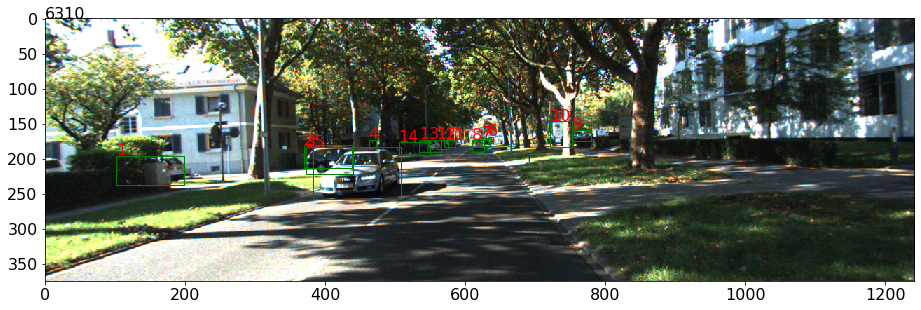

In [55]:
# get an image
# img_idx = 5785
img_idx = np.random.choice(len(data_reader.img_ids))
modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(img_idx, with_gt=True)
img_path = os.path.join(img_root, image_fn)
img = Image.open(img_path)
image = np.array(img)
height, width = img.height, img.width
plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i+1), color='r')
plt.show()

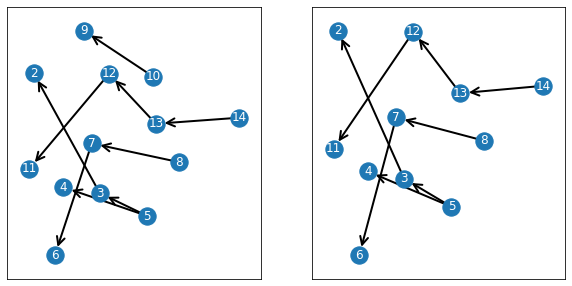

left: predicted ordering graph, right: ground truth ordering graph. Acc: 1.0


In [56]:
# infer ordering
gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3., single_ratio=1.5)
order_matrix = infer.infer_order(
    tester.model, image, modal, category, bboxes,
    use_rgb=tester.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=False)
allpair_true, allpair, occpair_true, occpair, show_err = infer.eval_order(order_matrix, gt_order_matrix)
acc_occpair = occpair_true / occpair
plt.figure(figsize=(10,5))
plt.subplot(121)
pos = draw_graph(order_matrix)
plt.subplot(122)
draw_graph(gt_order_matrix, pos=pos)
plt.show()
print('left: predicted ordering graph, right: ground truth ordering graph. Acc: {}'.format(acc_occpair))

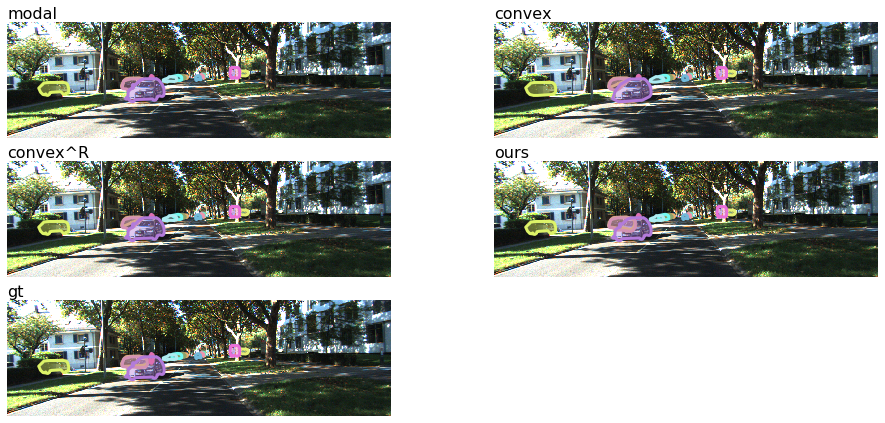

In [57]:
# amodal completion

# convex hull
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx, order_grounded=True))

# ours
amodal_patches_pred = infer.infer_amodal(
    tester.model, image, modal, category, bboxes, order_matrix,
    use_rgb=tester.use_rgb, th=0.2, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='linear', debug_info=False)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp='linear')

# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours', 'gt']

# highlight = [np.array([1,1,0.4]), np.array([0.4,1,1]),np.array([0.4,1,0.4])]
colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
# colors[12] = highlight[0]
# colors[1] = highlight[0]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=3)
    ax.add_collection(pface)
    ax.add_collection(pedge)
# plt.savefig('outputs/amodal_display/kins_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/kins_{}_img.jpg".format(img_idx),
#             image_resize(image_sub[:,:,::-1], long_size=480))
plt.show()

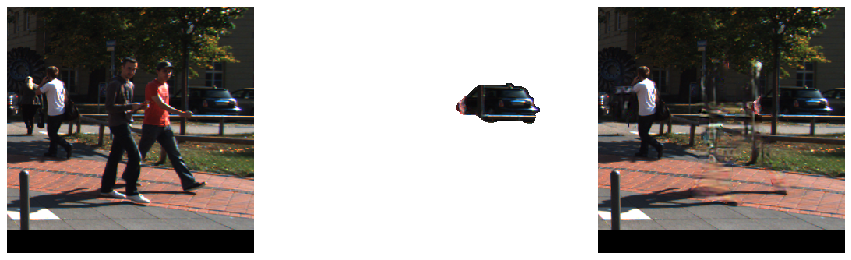

In [267]:
# decomposition
if False:
    inmodal_patches = [infer.resize_mask(
        utils.crop_padding(modal[i], bboxes[i], pad_value=(0,)), 256, 'linear') 
                           for i in range(bboxes.shape[0])]
    amodal_patches_pred = [infer.resize_mask(
        utils.crop_padding(amodal_gt[i], bboxes[i], pad_value=(0,)), 256, 'linear') 
                           for i in range(bboxes.shape[0])]
    
fg_idx = list(range(1,12))
fg_idx = [3,4,5,11]
fg_idx = [i-1 for i in fg_idx]
show_idx = 3
fg_dilate = 0
bg_dilate = 0
# brightness
# image_adj = gammaCorrection(image, gamma=0.7)
image_adj = image.copy()
# global box
involved_bbox = ori_bboxes[[i for i in fg_idx], :]
global_bbox = [involved_bbox[:,0].min(), involved_bbox[:,1].min(), 
               (involved_bbox[:,0] + involved_bbox[:,2]).max(),
               (involved_bbox[:,1] + involved_bbox[:,3]).max()]
global_bbox[2] = global_bbox[2] - global_bbox[0]
global_bbox[3] = global_bbox[3] - global_bbox[1]
global_bbox = expand_bbox([global_bbox], 1.1)[0]
crop_image = utils.crop_padding(
    image_adj, global_bbox, pad_value=(0,0,0))

# decomp
rgb_decomps = []
mask_decomps = []
for i in fg_idx:
    ret = inpaint(image_adj, bboxes, inmodal_patches, amodal_patches_pred, category, i, fg_dilate, False)
    ret = utils.crop_padding(ret, global_bbox, pad_value=(255,255,255))
    mask = np.tile(utils.crop_padding(amodal_pred[i], global_bbox, pad_value=(0,))[:,:,np.newaxis], (1,1,3))
    ret[mask == 0] = 255
    rgb_decomps.append(ret)
    mask_decomps.append(mask)

# bkg inpaint
bkg, vsb_mask = bkg_inpaint(image_adj, modal, fg_idx, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

# show
plt.figure(figsize=(15, 30./img.width*img.height))
ax = plt.subplot(131)
plt.imshow(crop_image)
plt.axis('off')
plt.subplot(132)
if show_idx == -1:
    plt.imshow(bkg)
else:
    this_obj = rgb_decomps[fg_idx.index(show_idx-1)]
    plt.imshow(this_obj)
plt.axis('off')
plt.subplot(133)
canvas = bkg.copy()
this_obj = rgb_decomps[fg_idx.index(show_idx-1)]
this_mask = mask_decomps[fg_idx.index(show_idx-1)]
canvas[this_mask == 1] = this_obj[this_mask == 1]
plt.imshow(canvas)
plt.axis('off')
plt.show()

# for i, (mask, obj) in enumerate(zip(mask_decomps, rgb_decomps)):
#     alpha = mask[:,:,:1] * 255
#     cv2.imwrite('outputs/isolated/obj_{}.png'.format(i), np.concatenate((obj[:,:,::-1], alpha), axis=2))
# cv2.imwrite('outputs/isolated/bkg.png', bkg[:,:,::-1])

# for i, (mask, obj) in enumerate(zip(mask_decomps, rgb_decomps)):
#     canvas = bkg.copy()
#     canvas[mask == 1] = obj[mask == 1]
#     alpha = mask[:,:,:1] * 255
#     cv2.imwrite('outputs/decomps/obj_{}.png'.format(i), np.concatenate((canvas[:,:,::-1], alpha), axis=2))
# cv2.imwrite('outputs/decomps/bkg.png', bkg[:,:,::-1])

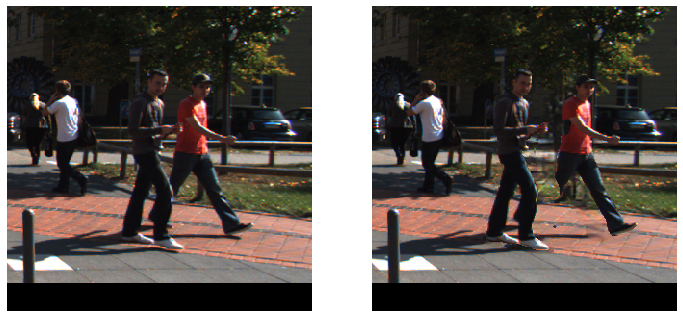

True

In [298]:
# recomposition inpainting
mode = 'shift'
foreground = [3,4,5,11]
original_order = [3,4,5,11]
if mode == 'random':
    offset = [np.random.choice(range(-50, 50), (2,)) for i in fg_idx]
    scale = [np.random.uniform(0.5, 1.5) for i in fg_idx]
elif mode == 'swap':
    order = original_order
    offset = [(0,0),(-65, -10),(67, 10), (0,0)]
    scale = np.ones((len(order),))
    scale[order.index(5)] = 0.9
    scale[order.index(4)] = 1.1
elif mode == 'move':
    order = original_order
    offset = [(0,0), (0,0), (115,45), (0,0)]
    scale = np.ones((len(order),))
    scale[order.index(5)] = 0.65
elif mode == 'shift':
    order = original_order
    offset = [(0,0) for i in foreground]
    offset[1] = (20,0)
    scale = np.ones((len(order),))
elif mode == 'delete':
    order = [3,4,11]
    offset = [(0,0) for i in foreground]
    scale = np.ones((len(order),))

rgb_decomps_bsl = []
mask_decomps_bsl = []
for i in fg_idx:
    ret = utils.crop_padding(image, global_bbox, pad_value=(255,255,255))
    mask = np.tile(utils.crop_padding(modal[i], global_bbox, pad_value=(0,))[:,:,np.newaxis], (1,1,3))
    ret[mask == 0] = 255
    rgb_decomps_bsl.append(ret)
    mask_decomps_bsl.append(mask)
    
# bkg inpaint
bg_dilate=5
bkg, vsb_mask = bkg_inpaint(image, modal, foreground, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

dilate_kernel = np.ones((len(fg_idx),), dtype=np.int) * 3
canvas = bkg.copy()
h, w = canvas.shape[:2]
for i, ind in enumerate(order):
    ind -= 1
    bbox = (-offset[i][0], -offset[i][1], 1./scale[i] * w, 1./scale[i] * h)
    shift_rgb = cv2.resize(utils.crop_padding(rgb_decomps_bsl[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                           (w, h), interpolation=cv2.INTER_CUBIC)
    shift_mask = infer.resize_mask(utils.crop_padding(mask_decomps_bsl[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                            h, 'linear')
    if dilate_kernel[i] > 0:
        shift_mask = 1 - cv2.dilate(
            1-shift_mask, np.ones((dilate_kernel[i], dilate_kernel[i]),np.uint8), iterations=1)
    canvas[shift_mask==1] = shift_rgb[shift_mask==1]
# show(rgb_decomps_bsl)
show([crop_image,canvas])
cv2.imwrite('outputs/recomp/kins_image.png', crop_image[:,:,::-1])
# cv2.imwrite('outputs/recomp/kins_{}_inpaint.png'.format(mode), canvas[:,:,::-1])

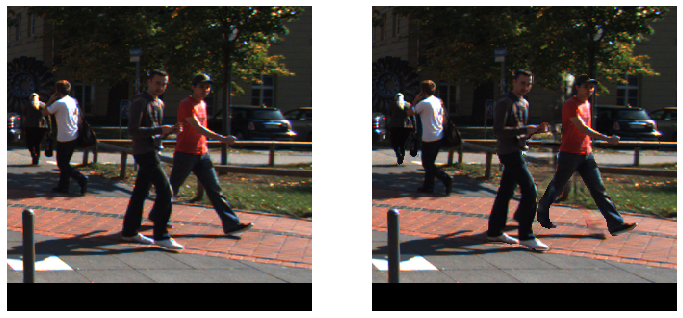

True

In [296]:
# recomposition
mode = 'shift'
foreground = [3,4,5,11]
original_order = [3,4,5,11]
if mode == 'random':
    order = np.random.permutation(fg_idx) + 1
    offset = [np.random.choice(range(-50, 50), (2,)) for i in fg_idx]
    scale = [np.random.uniform(0.5, 1.5) for i in fg_idx]
elif mode == 'swap':
    order = [3,5,4,11]
    offset = [(0,0),(67, 10), (-65, -10),(0,0)]
    scale = np.ones((len(order),))
    scale = np.ones((len(order),))
    scale[order.index(5)] = 0.9
    scale[order.index(4)] = 1.1
elif mode == 'move':
    order = [3,5,4,11]
    offset = [(0,0), (115,45), (0,0), (0,0)]
    scale = np.ones((len(order),))
    scale[order.index(5)] = 0.65
elif mode == 'shift':
    offset = [(0,0) for i in foreground]
    offset[1] = (20,0)
    scale = np.ones((len(order),))
elif mode == 'delete':
    order = [3,4,11]
    offset = [(0,0), (0,0), (0,0)]
    scale = np.ones((len(order),))
    
# bkg inpaint
bg_dilate = 0
bkg, vsb_mask = bkg_inpaint(image_adj, modal, fg_idx, bg_dilate, global_bbox)
bkg = cv2.resize(bkg, tuple(global_bbox[2:]), interpolation=cv2.INTER_CUBIC)
vsb_mask = infer.resize_mask(vsb_mask, global_bbox[2], interp='linear')
for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = crop_image[:,:,c][vsb_mask == 1]

dilate_kernel = [3 for _ in order]
canvas = bkg.copy()
h, w = canvas.shape[:2]
for i, ind in enumerate(order):
    ind -= 1
    bbox = (-offset[i][0], -offset[i][1], 1./scale[i] * w, 1./scale[i] * h)
    shift_rgb = cv2.resize(utils.crop_padding(rgb_decomps[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                           (w, h), interpolation=cv2.INTER_CUBIC)
    shift_mask = infer.resize_mask(utils.crop_padding(mask_decomps[fg_idx.index(ind)], bbox, pad_value=(0,0,0)),
                            h, 'linear')
    if dilate_kernel[i] > 0:
        shift_mask = 1 - cv2.dilate(
            1-shift_mask, np.ones((dilate_kernel[i], dilate_kernel[i]),np.uint8), iterations=1)
    canvas[shift_mask==1] = shift_rgb[shift_mask==1]
show([crop_image,canvas])
# show([bkg] + rgb_decomps, cols=2)
cv2.imwrite('outputs/recomp/kins_{}.png'.format(mode), canvas[:,:,::-1])